---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Email Prediction

In [10]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

Company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [34]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


<IPython.core.display.Javascript object>


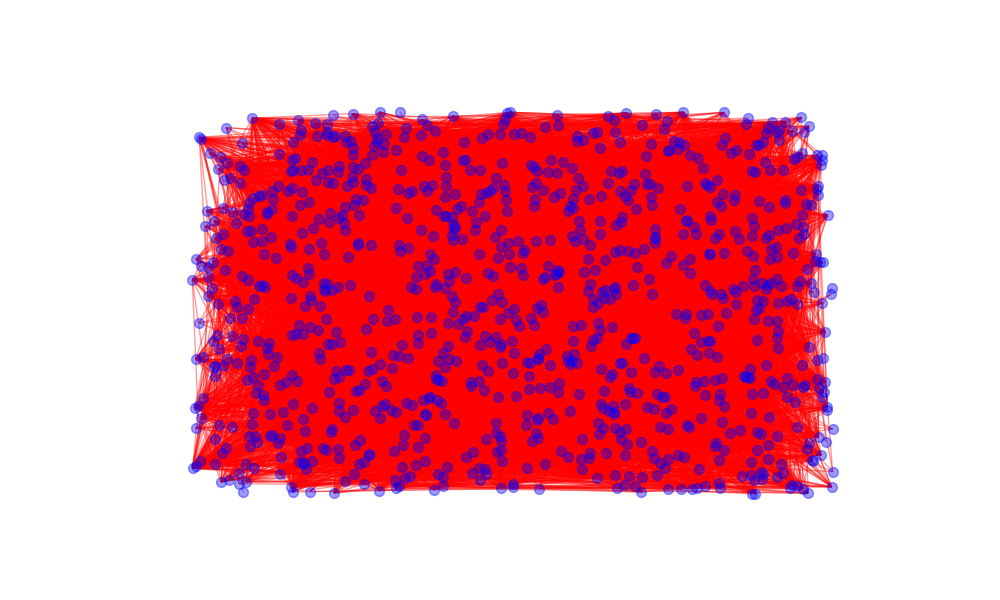

In [46]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
nx.draw_networkx(G, pos=nx.random_layout(G), with_labels=False, node_size=50, alpha=0.4, node_color='b', edge_color='r')

_ = plt.gca().axis("off")

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler


def is_management(node):
    managementSalary = node[1]['ManagementSalary']
    if managementSalary == 0:
        return 0
    elif managementSalary == 1:
        return 1
    else:
        return None

df = pd.DataFrame(index=G.nodes())
df['clustering'] = pd.Series(nx.clustering(G))
df['degree'] = pd.Series(G.degree())
df['degree_centrality'] = pd.Series(nx.degree_centrality(G))
df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized=True))
df['betweeness'] = pd.Series(nx.betweenness_centrality(G, normalized=True))
df['pr'] = pd.Series(nx.pagerank(G))
df['is_management'] = pd.Series([is_management(node) for node in G.nodes(data=True)])
df_train = df[~pd.isnull(df['is_management'])]
df_test = df[pd.isnull(df['is_management'])]
features = ['clustering', 'degree', 'degree_centrality', 'closeness', 'betweeness', 'pr']
X_train = df_train[features]
Y_train = df_train['is_management']
X_test = df_test[features]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = MLPClassifier(hidden_layer_sizes = [10, 5], alpha = 5,
                   random_state = 0, solver='lbfgs', verbose=0)
clf.fit(X_train_scaled, Y_train)
test_proba = clf.predict_proba(X_test_scaled)[:, 1]

pd.Series(test_proba,X_test.index)


1       0.128439
2       0.586261
5       0.979859
8       0.133702
14      0.304625
18      0.208766
27      0.269586
30      0.336144
31      0.169191
34      0.143513
37      0.096221
40      0.195036
45      0.162267
54      0.249954
55      0.252905
60      0.176908
62      0.992842
65      0.551284
77      0.078478
79      0.132108
97      0.099812
101     0.057517
103     0.214342
108     0.122930
113     0.454489
122     0.044350
141     0.396296
142     0.863703
144     0.072049
145     0.419966
          ...   
913     0.045734
914     0.078520
915     0.002087
918     0.144304
923     0.035175
926     0.090079
931     0.055969
934     0.013933
939     0.011147
944     0.002353
945     0.039608
947     0.162715
950     0.098173
951     0.038313
953     0.027345
959     0.002922
962     0.002440
963     0.139886
968     0.110279
969     0.104672
974     0.095061
984     0.012668
987     0.110375
989     0.113364
991     0.116944
992     0.003956
994     0.003077
996     0.0024

# Future Connections between Employees - Prediction

In [8]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


In [11]:
for node in G.nodes():
    G.node[node]["community"] = G.node[node]["Department"]

pref =  list(nx.preferential_attachment(G))
df = pd.DataFrame(index= [(x[0],x[1]) for x in pref])
df["pref"] = [x[2] for x in pref]

cn_soundarajan_hopcroft = list(nx.cn_soundarajan_hopcroft(G))
df_cn_soundarajan_hopcroft = pd.DataFrame(index=[(x[0], x[1]) for x in cn_soundarajan_hopcroft])
df_cn_soundarajan_hopcroft['cn_soundarajan_hopcroft'] = [x[2] for x in cn_soundarajan_hopcroft]
df = df.join(df_cn_soundarajan_hopcroft,how='outer')
df['cn_soundarajan_hopcroft'] = df['cn_soundarajan_hopcroft'].fillna(value=0)
df['resource_allocation_index'] = [x[2] for x in list(nx.resource_allocation_index(G))]
df['jaccard_coefficient'] = [x[2] for x in list(nx.jaccard_coefficient(G))]

df = future_connections.join(df,how='outer')
df_train = df[~pd.isnull(df['Future Connection'])]
df_test = df[pd.isnull(df['Future Connection'])]
features = ['cn_soundarajan_hopcroft', 'pref', 'resource_allocation_index', 'jaccard_coefficient']
X_train = df_train[features]
Y_train = df_train['Future Connection']
X_test = df_test[features]
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
clf = MLPClassifier(hidden_layer_sizes = [10, 5], alpha = 5,
                   random_state = 0, solver='lbfgs', verbose=0)
clf.fit(X_train_scaled, Y_train)
test_proba = clf.predict_proba(X_test_scaled)[:, 1]
predictions = pd.Series(test_proba,X_test.index)
target = future_connections[pd.isnull(future_connections['Future Connection'])].drop("Future Connection", axis=1)
target['prob'] = [predictions[x] for x in target.index]

target

,prob
"(107, 348)",0.030798
"(542, 751)",0.012661
"(20, 426)",0.590189
"(50, 989)",0.012774
"(942, 986)",0.012896
"(324, 857)",0.012758
"(13, 710)",0.157992
"(19, 271)",0.107565
"(319, 878)",0.012813
"(659, 707)",0.012673
